In [24]:
import pandas as pd
from tsfresh import extract_features
from sklearn.base import BaseEstimator, TransformerMixin
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score


# from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

# src code

In [2]:
class TSFreshFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, default_fc_parameters=None, column_id=None, column_sort=None, n_jobs=3):
        self.default_fc_parameters = default_fc_parameters
        self.column_id = column_id
        self.column_sort = column_sort
        self.n_jobs = n_jobs
    
    def fit(self, X, y=None):
        # No fitting necessary, just return self
        return self
    
    def transform(self, X):
        # Extract features using tsfresh
        extracted_features = extract_features(X, column_id=self.column_id, column_sort=self.column_sort,
                                              default_fc_parameters=self.default_fc_parameters,
                                              n_jobs=self.n_jobs)
        # Return only the extracted features dataframe
        return extracted_features

In [3]:
def loading_data():
    # Read each file into a DataFrame
    df_PS2 = pd.read_csv("../data_subset/PS2.txt", sep="\t", header=None)
    df_FS1 = pd.read_csv("../data_subset/FS1.txt", sep="\t", header=None)
    df_profile = pd.read_csv("../data_subset/profile.txt", sep="\t", header=None)
    
    df_profile.columns = ['cooler_condition_%', 'valve_condition_%', 'internal_pump_leakage',
                          'hydraulic_accumulator_bar', 'stable_flag' ]
    return df_PS2, df_FS1, df_profile

In [4]:
def resample_dataframes(df_PS2, df_FS1):
    # Transpose the FS1 DataFrame to have time series as rows
    df_FS1_transposed = df_FS1.T
    
    # Create a datetime index for the transposed FS1 DataFrame
    fs1_time_index = pd.date_range(start='2024-01-01', periods=len(df_FS1_transposed), freq='10ms')
    df_FS1_transposed.index = fs1_time_index
    
    # Resample FS1 to match the frequency of PS2 (from 10 Hz to 100 Hz)
    df_FS1_resampled_transposed = df_FS1_transposed.resample('10ms').interpolate()
    
    # Transpose back to the original format
    df_FS1_resampled = df_FS1_resampled_transposed.T
    
    # Transpose the PS2 DataFrame to have time series as rows
    df_PS2_transposed = df_PS2.T
    
    # Create a datetime index for the transposed PS2 DataFrame
    ps2_time_index = pd.date_range(start='2024-01-01', periods=len(df_PS2_transposed), freq='10ms')
    df_PS2_transposed.index = ps2_time_index
    
    # Resample PS2 to match the frequency of FS1 (from 100 Hz to 10 Hz)
    df_PS2_resampled_transposed = df_PS2_transposed.resample('100ms').interpolate()
    
    # Transpose back to the original format
    df_PS2_resampled = df_PS2_resampled_transposed.T
    return df_PS2_resampled, df_FS1_resampled

In [5]:
def wrangling_for_tsfresh(df):
    # Reset index to convert the timestamps to a regular column
    df = df.reset_index()
    
    # Melt the DataFrame to create the 'id', 'timestamp', and 'value' columns
    df_melted = pd.melt(df, id_vars=['index'], var_name='timestamp', value_name='value')
    
    # Rename the columns
    df_melted.columns = ['id', 'timestamp', 'value']
    
    # Sort by 'id' for better clarity
    df_melted = df_melted.sort_values(by='id').reset_index(drop=True)
    return df_melted

In [6]:
def train_test_split_(X, y, nb_cycles=2000):
    X_train_test, X_val = df_full[lambda x: x["id"]<=(nb_cycles-1)], df_full[lambda x: x["id"]>(nb_cycles-1)]
    y_train_test, y_val = y.iloc[:nb_cycles], y.iloc[nb_cycles:]
    return X_train_test, X_val, y_train_test, y_val
    

In [7]:
def pipeline_creation(X_train, y_train):
    # Define the pipeline
    pipeline = Pipeline([
        ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='timestamp', n_jobs=3)),
        ('classifier', XGBClassifier(
            # random_state=42,
            # n_estimators=100,  # Number of trees in the ensemble
            # max_depth=2,  # Maximum depth of each tree
            # learning_rate=0.1,  # Step size shrinkage used in update to prevent overfitting
            # min_child_weight=1,  # Minimum sum of instance weight (hessian) needed in a child
            # subsample=0.8,  # Subsample ratio of the training instance
            # colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
            # reg_alpha=0,  # L1 regularization term on weights
            # reg_lambda=1,  # L2 regularization term on weights
            # gamma=0,  # Minimum loss reduction required to make a further partition on a leaf node of the tree
        ))  # XGBoost classifier
    ])
    
    # Define the evaluation metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    pipeline.set_params(augmenter__timeseries_container=X_train)
    # Perform time series cross-validation
    cv_results = cross_validate(pipeline, X_train, y_train, cv=TimeSeriesSplit(n_splits=5), scoring=scoring)
    
    # Compute relevant metrics
    metrics_df = pd.DataFrame({
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall'],
        'F1': cv_results['test_f1'],
        'AUC': cv_results['test_roc_auc']
    })
    return pipeline, cv_results, metrics_df


In [8]:
def validation_score(pipeline, X_train, y_train, X_test, y_test):
    pipeline.set_params(augmenter__timeseries_container=X_train)
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Predict the target variable on the test data
    y_pred = pipeline.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1],
        'AUC': [roc_auc]
    })
    return metrics_df

In [9]:
def preprocessing(df):
    df_extracted_features = extract_features(df, column_id="id", column_sort="timestamp", n_jobs=4)
    return df_extracted_features

# Main code 

In [10]:
# def main():
# loading data
df_PS2, df_FS1, df_profile = loading_data()
# resampling data with same frequency 
df_PS2_resampled, df_FS1_resampled = resample_dataframes(df_PS2, df_FS1)
# data wrangling - for tsfresh 
df_PS2_melted = wrangling_for_tsfresh(df_PS2_resampled)
df_FS1_melted = wrangling_for_tsfresh(df_FS1_resampled) #[lambda x: x.id==0]

In [11]:
# full dataframe 
df_full = pd.concat([df_FS1_melted.rename(columns={'value': 'fs1'}),
                     df_PS2_melted.rename(columns={'value': 'ps2'})['ps2']], axis=1)
# adding target variable to dataframe 
# df_to_model = pd.concat([df_full, df_profile["valve_condition_%"]], axis=1)
# Changing target variable into a binary variable 100=1, the rest=0
df_profile["valve_condition_%"] = np.where(df_profile["valve_condition_%"] == 100, 1, 0)
# train-test split
X_train_test, X_val, y_train_test, y_val = train_test_split_(df_full, df_profile["valve_condition_%"], nb_cycles=2000)

# tsfresh

In [39]:
# preprocessing X_train_test and X_val with tsfresh
X_train_test_tsf = preprocessing(X_train_test)
X_val_tsf = preprocessing(X_val)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.91s/it]


In [40]:
# storing preprocessed data
X_train_test_tsf.to_csv("../data/X_train_test_tsf.csv")
X_val_tsf.to_csv("../data/X_val_tsf.csv")

In [41]:
X_train_test_tsf#.shape

,fs1__variance_larger_than_standard_deviation,fs1__has_duplicate_max,fs1__has_duplicate_min,fs1__has_duplicate,fs1__sum_values,fs1__abs_energy,fs1__mean_abs_change,fs1__mean_change,fs1__mean_second_derivative_central,fs1__median,...,ps2__fourier_entropy__bins_5,ps2__fourier_entropy__bins_10,ps2__fourier_entropy__bins_100,ps2__permutation_entropy__dimension_3__tau_1,ps2__permutation_entropy__dimension_4__tau_1,ps2__permutation_entropy__dimension_5__tau_1,ps2__permutation_entropy__dimension_6__tau_1,ps2__permutation_entropy__dimension_7__tau_1,ps2__query_similarity_count__query_None__threshold_0.0,ps2__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,1.0,1.0,4025.889,32459.560853,0.256631,-0.001593,0.007122,7.8360,...,0.090729,0.136002,0.497646,1.741937,3.024448,4.332795,5.331791,5.697601,NaN,141.620000
1,1.0,0.0,1.0,1.0,4029.189,32470.752509,0.247778,-0.001718,0.006715,7.8530,...,0.090729,0.136002,0.497646,1.755775,3.046643,4.392852,5.397248,5.733835,NaN,141.720000
2,1.0,0.0,1.0,1.0,4031.113,32525.450027,0.251705,-0.002048,0.007149,7.8470,...,0.090729,0.136002,0.497646,1.747789,2.999286,4.296197,5.304960,5.659033,NaN,141.321429
3,1.0,0.0,1.0,1.0,4032.339,32563.351133,0.249077,-0.002105,0.006858,7.8430,...,0.090729,0.136002,0.486899,1.748409,2.984955,4.299037,5.215527,5.609699,NaN,141.235714
4,1.0,0.0,1.0,1.0,4014.185,32288.726879,0.249613,-0.001509,0.006651,7.8310,...,0.090729,0.136002,0.486899,1.741888,3.005425,4.332695,5.283074,5.642980,NaN,141.171429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,0.0,1.0,1.0,3899.969,30654.642971,0.249967,-0.000855,0.005700,7.5895,...,0.090729,0.136002,0.497646,1.737286,3.013056,4.246419,5.216261,5.607992,NaN,144.061429
1996,1.0,0.0,1.0,1.0,3897.436,30552.935852,0.249509,-0.001078,0.006426,7.6065,...,0.090729,0.136002,0.497646,1.739452,3.023254,4.262357,5.241333,5.604535,NaN,143.950000
1997,1.0,0.0,1.0,1.0,3891.960,30458.149482,0.253943,-0.000868,0.005903,7.5955,...,0.090729,0.136002,0.497646,1.739312,3.029045,4.284707,5.235963,5.637378,NaN,144.011429
1998,1.0,0.0,1.0,1.0,3897.255,30609.219305,0.243270,-0.000783,0.005845,7.5955,...,0.090729,0.136002,0.497646,1.745147,3.015675,4.291684,5.301004,5.670337,NaN,144.020000


# Code to fix

In [120]:
# df_temp = df_profile.copy()
# df_temp["valve_condition_%"] = np.where(df_profile["valve_condition_%"]== 100, 1, 0)
# df = df_full.copy()
# nb_cycles=100

# X = df.copy()
# y = df_temp["valve_condition_%"].copy()
# y.value_counts()

valve_condition_%
1    1125
0    1080
Name: count, dtype: int64

In [50]:
# print(X_train_test.shape)
# print(y.iloc[:nb_cycles].shape)

(100, 4)
(100,)


In [103]:
# df_temp = df_profile.copy()
# df_temp["valve_condition_%"] = np.where(df_profile["valve_condition_%"]== 100, 1, 0)
# df = df_full.copy()
# nb_cycles=2000

# X = df.copy()
# y = df_temp["valve_condition_%"].copy()
# X_train_test, X_val = X.iloc[:nb_cycles], X.iloc[nb_cycles:]
# # y_train_test = y.sample(n=nb_cycles)
# y_train_test, y_val = y.iloc[:nb_cycles], y.iloc[nb_cycles:]
# # # Define the pipeline with only the first step
# # pipeline = Pipeline([
# #     ('feature_extractor', TSFreshFeatureExtractor(column_id='id', column_sort='timestamp')),
# #     ('classifier', XGBClassifier())
# # ])
# # # Fit the pipeline to your data and train the classifier
# # pipeline.fit(X_train_test, y_train_test)


In [54]:
# Define the pipeline with only the first step
pipeline = Pipeline([
    ('feature_extractor', TSFreshFeatureExtractor(column_id='id', column_sort='timestamp')),
    # ('feature_selection', SelectFromModel(XGBClassifier(), max_features=100)),  # XGBoost model for feature selection
    ('classifier', XGBClassifier())
])
# pipeline.set_output(transform="pandas")
# Fit the pipeline to your data and train the classifier
pipeline.fit(X_train_test, y_train_test)

Feature Extraction:  20%|███████████████▌                                                              | 3/15 [14:10<56:42, 283.54s/it]Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Process ForkPoolWorker-23:
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/tsfresh/utilities/distribution.py", line 43, in _function_with_partly_reduce
    results = list(itertools.chain.from_iterable(results))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/tsfresh/utiliti

In [31]:
# Transform the data and convert back to DataFrame
X_transformed_df = pipeline.transform(X_train_test)
X_transformed_df.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████| 4002/4002 [33:11<00:00,  2.01it/s]


,fs1__variance_larger_than_standard_deviation,fs1__has_duplicate_max,fs1__has_duplicate_min,fs1__has_duplicate,fs1__sum_values,fs1__abs_energy,fs1__mean_abs_change,fs1__mean_change,fs1__mean_second_derivative_central,fs1__median,...,ps2__fourier_entropy__bins_5,ps2__fourier_entropy__bins_10,ps2__fourier_entropy__bins_100,ps2__permutation_entropy__dimension_3__tau_1,ps2__permutation_entropy__dimension_4__tau_1,ps2__permutation_entropy__dimension_5__tau_1,ps2__permutation_entropy__dimension_6__tau_1,ps2__permutation_entropy__dimension_7__tau_1,ps2__query_similarity_count__query_None__threshold_0.0,ps2__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,1.0,1.0,4025.889,32459.560853,0.256631,-0.001593,0.007122,7.836,...,0.090729,0.136002,0.497646,1.741937,3.024448,4.332795,5.331791,5.697601,NaN,141.620000
1,1.0,0.0,1.0,1.0,4029.189,32470.752509,0.247778,-0.001718,0.006715,7.853,...,0.090729,0.136002,0.497646,1.755775,3.046643,4.392852,5.397248,5.733835,NaN,141.720000
2,1.0,0.0,1.0,1.0,4031.113,32525.450027,0.251705,-0.002048,0.007149,7.847,...,0.090729,0.136002,0.497646,1.747789,2.999286,4.296197,5.304960,5.659033,NaN,141.321429
3,1.0,0.0,1.0,1.0,4032.339,32563.351133,0.249077,-0.002105,0.006858,7.843,...,0.090729,0.136002,0.486899,1.748409,2.984955,4.299037,5.215527,5.609699,NaN,141.235714
4,1.0,0.0,1.0,1.0,4014.185,32288.726879,0.249613,-0.001509,0.006651,7.831,...,0.090729,0.136002,0.486899,1.741888,3.005425,4.332695,5.283074,5.642980,NaN,141.171429


In [46]:
X_transformed_df.shape

(2001, 1566)

In [47]:
# Predict labels for the test data
y_pred = pipeline.predict(X_train_test).ravel()
# Obtain the true labels for the test data
y_true = y_train_test  
report = classification_report(y_true, y_pred)
print(report)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [19:23<00:00, 58.18s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       948
           1       1.00      1.00      1.00      1052

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [49]:
X_val

,id,timestamp,fs1,ps2
1200000,2000,2024-01-01 00:00:05.280000,7.634,125.270
1200001,2000,2024-01-01 00:00:01.520000,7.750,120.410
1200002,2000,2024-01-01 00:00:00.450000,0.001,0.078
1200003,2000,2024-01-01 00:00:03.050000,7.607,139.740
1200004,2000,2024-01-01 00:00:01.330000,7.896,120.120
...,...,...,...,...
1322995,2204,2024-01-01 00:00:03.970000,8.131,130.860
1322996,2204,2024-01-01 00:00:03.960000,7.908,130.930
1322997,2204,2024-01-01 00:00:03.950000,8.288,130.650
1322998,2204,2024-01-01 00:00:03.930000,9.444,131.940


In [ ]:
# Predict labels for the test data
y_pred = pipeline.predict(X_val).ravel()
# Obtain the true labels for the test data
y_true = y_val  
report = classification_report(y_true, y_pred)
print(report)

In [ ]:
# cross-validation
print('CROSS-VALIDATION STARTED')
pipeline, cv_results, cv_metrics_df = pipeline_creation(X_train_test, y_train_test)
cv_metrics_df.to_csv("../data/cv_metrics_df.csv")
# validation performance 
print('VALIDATION STARTED')
val_metrics_df = validation_score(pipeline, X_train_test, y_train_test, X_val, y_val)
val_metrics_df.to_csv("../data/val_metrics_df.csv")

In [63]:
X_train_test.index

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
       1199990, 1199991, 1199992, 1199993, 1199994, 1199995, 1199996, 1199997,
       1199998, 1199999],
      dtype='int64', length=1200000)

In [60]:
sampled_X.index

Index([ 372605,  551204,  240320, 1047361,  555362, 1062538,  552662, 1021194,
        886200,  609792,  184524,  408157, 1164950,  475763,  533547,  722394,
        324056,  193880, 1192565, 1002564,  882091, 1095397,  431680,  965004,
        496677,  845364,  102091,  215845,  568057,  487784,  148241, 1028680,
         36451, 1110112,  145042, 1053198,  452276,  517133,  392694, 1135955,
        267150,  101859,  146876,  214320,   76748,  319616, 1056411,  907433,
        693565,  697215,   88734,  700160,    7378,  313996,  761156,  267308,
        972735,  332987, 1087056,  512400,  876451,  581496,  464616,  526090,
         37780,  705558,  979820,   16709,  757372,  457029,  387577,  280478,
        282602,  720904,  831525, 1100359,  899621, 1104340,  636336,  399099,
        348673,  226163, 1141597,   57300,  746288,  835775,  208422,  522531,
       1049521,   37105, 1073395,  566698,   10174, 1076455,  106289,  182308,
        911623,  835927,  194785, 1172729],
      dt

In [65]:
sampled_X.shape

(100, 4)

In [24]:
y_train_test.shape

(2000,)

In [23]:
X_train_test_tsf.shape

(2205, 1566)

# Code to modify

In [18]:
X_train_test_tsf = pd.read_csv("../data/X_train_test_tsf.csv", index_col=0)
X_val_tsf = pd.read_csv("../data/X_val_tsf.csv", index_col=0)

In [19]:
print(X_train_test_tsf.shape)
print(X_val_tsf.shape)

(2000, 1566)
(205, 1566)


In [32]:
# Define the pipeline with only the first step
pipeline = Pipeline([
    # ('feature_extractor', TSFreshFeatureExtractor(column_id='id', column_sort='timestamp')),
    # ('feature_selection', SelectFromModel(XGBClassifier(random_state=42), max_features=30)),  # XGBoost model for feature selection
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('variance_threshold', VarianceThreshold()),  # Remove constant features
    ('feature_selection', SelectKBest(score_func=f_classif, k=2)),  # Select top 10 features
    ('classifier', XGBClassifier(random_state=42))
])
pipeline.set_output(transform="pandas")
# Fit the pipeline to your data and train the classifier
pipeline.fit(X_train_test_tsf, y_train_test)

/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['fs1__query_similarity_count__query_None__threshold_0.0'
 'ps2__friedrich_coefficients__coeff_0__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_1__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_2__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_3__m_3__r_30'
 'ps2__max_langevin_fixed_point__m_3__r_30'
 'ps2__query_similarity_count__query_None__threshold_0.0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 53 786] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/feature_selection/_univariate_selection

Pipeline(steps=[('imputer', SimpleImputer()),
                ('variance_threshold', VarianceThreshold()),
                ('feature_selection', SelectKBest(k=2)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feat...ow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [33]:
# Get feature names used by the XGBoost model
xgb_feature_names = pipeline.named_steps['classifier'].get_booster().feature_names
print(xgb_feature_names)

['ps2__fft_coefficient__attr_"angle"__coeff_71', 'ps2__fft_coefficient__attr_"angle"__coeff_84']


In [34]:
len(xgb_feature_names)

2

In [35]:
# Predict labels for the test data
y_pred = pipeline.predict(X_val_tsf[X_train_test_tsf.columns]).ravel()
# Obtain the true labels for the test data
y_true = y_val  
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        73

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['fs1__query_similarity_count__query_None__threshold_0.0'
 'ps2__friedrich_coefficients__coeff_0__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_1__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_2__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_3__m_3__r_30'
 'ps2__max_langevin_fixed_point__m_3__r_30'
 'ps2__query_similarity_count__query_None__threshold_0.0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [49]:
# # Generate the classification report
# report_str = classification_report(y_true, y_pred)

# # Write the report string to a CSV file
# with open('../data/classification_report.csv', 'w') as f:
#     f.write(report_str)

In [36]:
y_pred = pipeline.predict(X_train_test_tsf).ravel()
# Obtain the true labels for the test data
y_true = y_train_test  
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       948
           1       1.00      1.00      1.00      1052

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['fs1__query_similarity_count__query_None__threshold_0.0'
 'ps2__friedrich_coefficients__coeff_0__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_1__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_2__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_3__m_3__r_30'
 'ps2__max_langevin_fixed_point__m_3__r_30'
 'ps2__query_similarity_count__query_None__threshold_0.0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [37]:
# Define scoring metrics
scoring = {'AUC': 'roc_auc'}

# Perform cross-validation
cv_results = cross_validate(pipeline, X_train_test_tsf, y_train_test, scoring=scoring, cv=5, return_train_score=True)

# Create a DataFrame to store train and test performances
results_df = pd.DataFrame({
    'Train AUC': cv_results['train_AUC'],
    'Test AUC': cv_results['test_AUC']
})

# Calculate mean and standard deviation
results_df.loc['Mean'] = results_df.mean()
results_df.loc['Std'] = results_df.std()

/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['fs1__query_similarity_count__query_None__threshold_0.0'
 'ps2__friedrich_coefficients__coeff_0__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_1__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_2__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_3__m_3__r_30'
 'ps2__max_langevin_fixed_point__m_3__r_30'
 'ps2__query_similarity_count__query_None__threshold_0.0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 53 786] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/feature_selection/_univariate_selection

In [42]:
cv_results

{'fit_time': array([1.37663627, 0.46206498, 0.81139016, 1.22517848, 0.80442405]),
 'score_time': array([0.02569032, 0.02617145, 0.02599359, 0.02746153, 0.02700925]),
 'test_AUC': array([1.        , 0.99330475, 1.        , 1.        , 1.        ]),
 'train_AUC': array([0.99999765, 1.        , 1.        , 1.        , 1.        ])}

In [53]:
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define scoring metrics
scoring = {'Train AUC': 'roc_auc', 'Test AUC': 'roc_auc'}

# Perform time series cross-validation
cv_results = cross_validate(pipeline, X_train_test_tsf, y_train_test, cv=tscv, scoring=scoring, return_train_score=True)

# Create a DataFrame to store train and test performances
results_df = pd.DataFrame({
    'Train AUC': cv_results['train_Train AUC'],
    'Test AUC': cv_results['test_Test AUC']
})

# Calculate mean and standard deviation
results_df.loc['Mean'] = results_df.mean()
results_df.loc['Std'] = results_df.std()

results_df


/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['fs1__query_similarity_count__query_None__threshold_0.0'
 'ps2__friedrich_coefficients__coeff_0__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_1__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_2__m_3__r_30'
 'ps2__friedrich_coefficients__coeff_3__m_3__r_30'
 'ps2__max_langevin_fixed_point__m_3__r_30'
 'ps2__query_similarity_count__query_None__threshold_0.0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 50 778] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/adelchiasta/venv/venv_vif_dataswati/lib64/python3.11/site-packages/sklearn/feature_selection/_univariate_selection

,Train AUC,Test AUC
0,1.000000,0.997797
1,1.000000,1.000000
2,1.000000,1.000000
3,1.000000,1.000000
4,0.999997,1.000000
Mean,0.999999,0.999559
Std,0.000001,0.000881


In [39]:
def pearson_correlation(X):
    data = X
    corr_pearson = data.corr(method='pearson')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_pearson)
    # drop correlated feature
    # Return a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_pearson.shape[0],), True, dtype=bool) 
    for i in range(corr_pearson.shape[0]):
        for j in range(i+1, corr_pearson.shape[0]):
            if corr_pearson.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_pearson = data.columns[columns]
    return selected_columns_pearson, corr_pearson

def spearman_correlation(X):
    data = X
    corr_spearman = data.corr(method='spearman')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    # Returns a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_spearman.shape[0],), True, dtype=bool) 
    for i in range(corr_spearman.shape[0]):
        for j in range(i+1, corr_spearman.shape[0]):
            if corr_spearman.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_spearman = data.columns[columns]
    return selected_columns_spearman, corr_spearman

(Index(['ps2__fft_coefficient__attr_"angle"__coeff_71', 'valve_condition_%'], dtype='object'),
                                               ps2__fft_coefficient__attr_"angle"__coeff_71  \
 ps2__fft_coefficient__attr_"angle"__coeff_71                                      1.000000   
 ps2__fft_coefficient__attr_"angle"__coeff_84                                      0.876717   
 valve_condition_%                                                                      NaN   
 
                                               ps2__fft_coefficient__attr_"angle"__coeff_84  \
 ps2__fft_coefficient__attr_"angle"__coeff_71                                      0.876717   
 ps2__fft_coefficient__attr_"angle"__coeff_84                                      1.000000   
 valve_condition_%                                                                      NaN   
 
                                               valve_condition_%  
 ps2__fft_coefficient__attr_"angle"__coeff_71                NaN  
 ps2__f

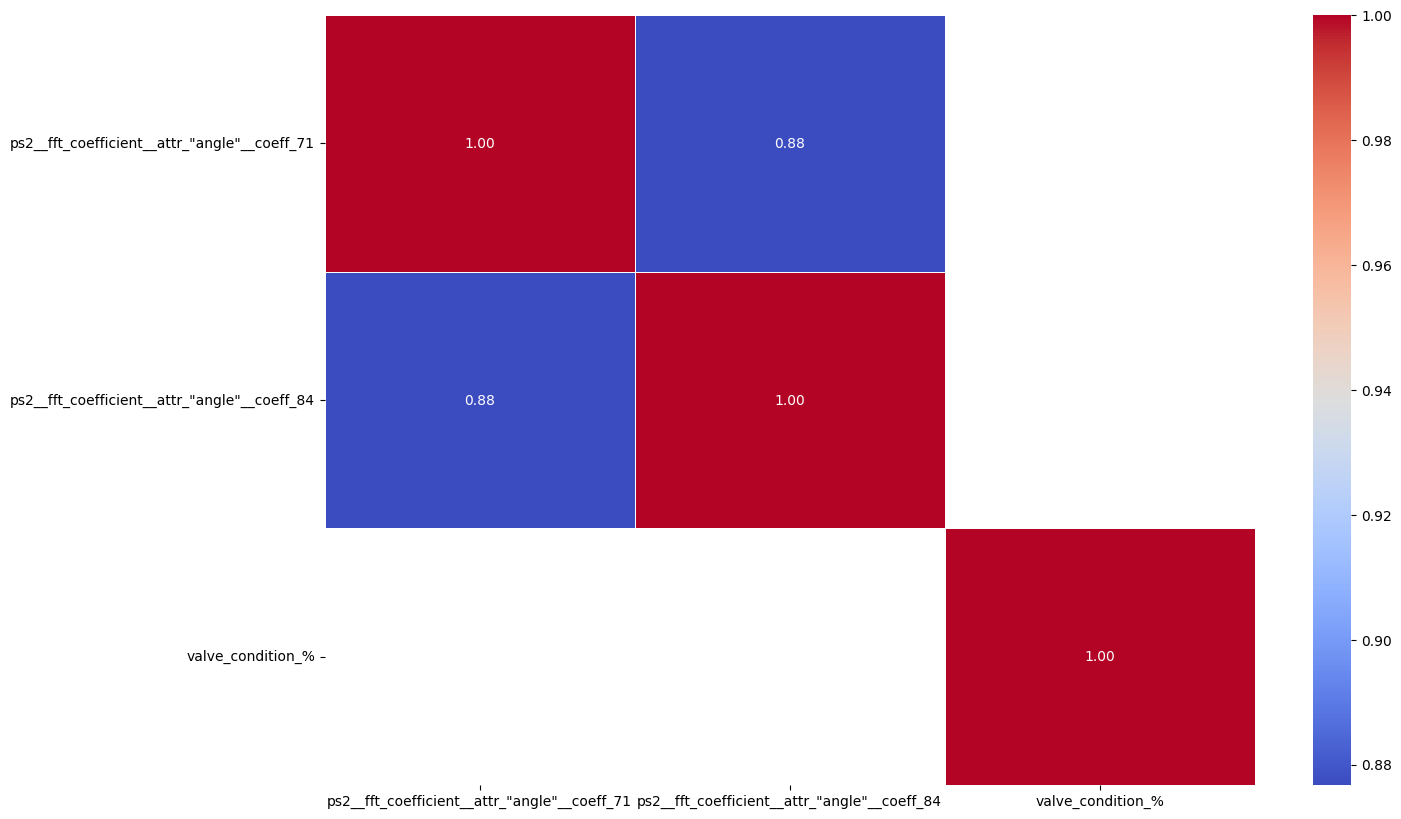

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

df_tmp = pd.concat([X_train_test_tsf[xgb_feature_names], y_train_test])
spearman_correlation(df_tmp)


In [41]:
import numpy as np
from scipy.stats import pearsonr, pointbiserialr

# Define the feature name for which you want to compute the correlation
feature_name = 'ps2__fft_coefficient__attr_"angle"__coeff_71'

# Check if the feature is binary or continuous
if len(np.unique(X_train_test_tsf[feature_name])) == 2:  # Binary feature
    correlation, _ = pointbiserialr(X_train_test_tsf[feature_name], y_train_test)
else:  # Continuous feature
    correlation, _ = pearsonr(X_train_test_tsf[feature_name], y_train_test)

print(f"Correlation between {feature_name} and target: {correlation}")

Correlation between ps2__fft_coefficient__attr_"angle"__coeff_71 and target: -0.982438795085749
